In [1]:
# Name: example_velocity_dependence.ipynb
# Authors: Stephan Meighen-Berger
# Studies the velocity dependence of the emissions

In [14]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from tqdm import tqdm

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config

In [6]:
# Scenario Settings
# These are general settings pertaining to the simulation run
config['scenario']['population size'] = 2  # The starting population size
config['scenario']['exclusion'] = True  # If an exclusion zone should be used (the detector)
config['scenario']['injection']['y range'] = [0.5 * 15. - 0.15 - 2.5, 0.5 * 15. - 0.15 + 2.5]  # The y-range of injection
config['scenario']['light prop'] = {  # Where the emitted light should be propagated to (typically the detector location)
            "switch": False,  # If light should be propagated
            "x_pos": 3.,  # The x-coordinates
            "y_pos": 0.5 * 15. - 0.15,  # The y-coordinates
        }
config['scenario']['detector'] = {  # detector specific properties, positions are defined as offsets from the light prop values
    "switch": False,  # If the detector should be modelled
    "type": "PMTSpec",  # Detector name, implemented types are given in the config
    "response": True,  # If a detector response should be used
    "acceptance": "Flat",  # Flat acceptance
    "mean detection prob": 0.5  # Used for the acceptance calculation
}
# ---------------------------------------------
# Organisms
# Organisms properties are defined here
config['organisms']['emission fraction'] = 0.05  # Amount of energy an organism uses per pulse
config['organisms']['alpha'] = 1e0  # Proportionality factor for the emission probability
config['organisms']["minimal shear stress"] = 0.1  # The minimal amount of shear stress needed to emit (generic units)
config["organisms"]["filter"] = 'depth'  # Method of filtering organisms (here depth)
config["organisms"]["depth filter"] = 1000.  # Organisms need to exist below this depth
# ---------------------------------------------
# Geometry
# These settings define the geometry of the system
# Typically a box (simulation volume) with a spherical exclusion zone (detector)
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 30.,
    'y_length': 15.,
    'offset': None,
}
# Reduce the observation size to reduce the computational load
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 30.,
    'y_length': 15.,
    "offset": np.array([0., 0.]),
}
# The detector volume
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 3.,
    "y_pos": 0.5 * 15. - 0.15,
}
# ---------------------------------------------
# Water
# Properties of the current model
config['water']['model']['name'] = 'custom'  # Use a custom (non analytic) model
config['water']['model']['off set'] = np.array([0., 0.])  # Offset of the custom model

In [7]:
# Density function
# Converts a given density organisms/m^3 to something usable by Fourth Day
def dens2fd(density, ylength, current_velocity):
    # Injection density
    injection_volume_per_time_step = ylength * current_velocity
    org_per_time_step = injection_volume_per_time_step * density
    return org_per_time_step

In [16]:
# The final value is the conversion factor to hours
water_models = [
    ["run_2cm_npy/", 0.02, 5, r'$2\;\mathrm{cm/s}$', 'pink', 2.4],
    ["run_5cm_npy/", 0.05, 2.5, r'$5\;\mathrm{cm/s}$', 'purple', 6.],
    ["run_10cm_npy/", 0.1, 1, r'$10\;\mathrm{cm/s}$', 'r', 12.]]  # The arrays in this analysis have differing time steps, for the different velocities
model_data = {}
for model in water_models:
    peak_arr = []
    for seed in tqdm(range(100)):
        inject_org = dens2fd(1e-1, 5., model[1])
        config['general']["random state seed"] = seed  # Seed
        config['scenario']['duration'] = int(600 * model[2])  # Total simulation time in seconds
        config['scenario']['injection']['rate'] = inject_org  #  Injection rate in per second, a distribution is constructed from this value
        config['water']['model']['directory'] = "../data/current/Parabola_5mm/" + model[0]  # The files used by the custom model
        config['water']['model']['time step'] = model[2]  # in Seconds
        # Creating a fourth_day object
        # Use this to interact with with the module
        fd = Fourth_Day()
        # Launching solver
        # This might take a while depending on the settings
        # Check the log file (standard setting is in the run folder) for the current iteration
        fd.sim()
        total_flashes = 0.
        # Skipping the first cycle
        warm_up = int(600 * model[2] / 2)
        for stat in fd.statistics[warm_up:]:
            total_flashes += np.sum(stat["pulse start"])
        peak_arr.append(total_flashes)
    peak_arr = np.array(peak_arr)
    model_data[model[0]] = peak_arr

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [51:43<00:00, 31.04s/it]


In [32]:
# Plotting standards
std_size = 3.  # Size of the plot
fontsize = 10.  # Fontsize in the plot
lw=1.  # Linewidth
h_length=0.2  # Handle length for the legends
export_dpi = 1000  # Dpi for the image export

In [22]:
# Font style
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

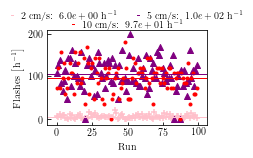

In [41]:
# Plot figure with subplots of different sizes
fig, ax1 = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------------------------------------------------------------
# The average emissions
m_styles = ["+", "^", "."]
for id_model, model in enumerate(water_models):
    ax1.scatter(
        range(100),
        model_data[model[0]] * model[5],
        # yerr=np.sqrt(model_data[model[0]] * model[5]),
        # ls='',
        # elinewidth=lw, capsize=10.,
        color=model[4], marker=m_styles[id_model])
for id_model, model in enumerate(water_models):
    ax1.axhline(np.mean(model_data[model[0]] * model[5]), 0., 1.,
                color=model[4], lw=lw,
                label=(model[3] + r'$:\; %.1e\;\mathrm{h^{-1}}$' % (np.mean(model_data[model[0]] * model[5]))))
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h[:2],l[:2], loc=9, bbox_to_anchor=(0.5, +1.3),
                  ncol=3, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
lgd2 = ax1.legend(h[2:],l[2:], loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=3, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.add_artist(lgd1)
# ---------------------------------------------------------------------------------------------------
ax1.set_xlabel(r'$\mathrm{Run}$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Flashes}\;\left[\mathrm{h}^{-1}\right]$', fontsize=fontsize)
# ---------------------------------------------------------------------------------------------------
# General
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()
fig.savefig(PICS + "Velocity_Dependence.png",
            bbox_inches='tight', dpi=export_dpi)
pickle.dump([water_models, model_data, 50], open("../data/storage/vel_plot.p", "wb"))